In [1]:
"""These are assumed to be ran after the production database is updated"""

import pandas as pd
import plotly.express as px

from mainnet_launch.database.postgres_operations import (
    _exec_sql_and_cache,
    get_full_table_as_df_with_tx_hash,
    get_full_table_as_df_with_block,
    get_full_table_as_df,
)
from mainnet_launch.database.schema.full import *

from mainnet_launch.slack_messages.post_message import post_slack_message, post_message_with_table
from mainnet_launch.constants import *

from mainnet_launch.data_fetching.get_events import fetch_events
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks


def fetch_all_balance_updated_events() -> str:
    all_balance_updated_df = get_full_table_as_df_with_tx_hash(IncentiveTokenBalanceUpdated)
    return all_balance_updated_df


def fetch_recent_vault_claimed_reward_events(n: int) -> str:
    balance_updated_events = fetch_all_balance_updated_events()  # todo switch to recent only

    n_days_ago = pd.Timestamp.now() - pd.Timedelta(days=n)

    get_recent_autopool_destination_states_query = f"""
              SELECT
                  autopool_destination_states.*,
                  destinations.pool as pool,
                  blocks.datetime
              FROM autopool_destination_states
              JOIN blocks
                ON autopool_destination_states.block = blocks.block
              AND autopool_destination_states.chain_id = blocks.chain_id
              JOIN destinations
                ON autopool_destination_states.destination_vault_address = destinations.destination_vault_address
                AND autopool_destination_states.chain_id = destinations.chain_id

              WHERE blocks.datetime > '{n_days_ago}'
              ORDER BY blocks.datetime DESC
    """

    get_recent_destination_states_query = f"""

          SELECT
          destination_states.*,
          destinations.pool as pool,
          blocks.datetime
          FROM destination_states
          JOIN blocks
          ON destination_states.block = blocks.block
          AND destination_states.chain_id = blocks.chain_id

          JOIN destinations
          ON destination_states.destination_vault_address = destinations.destination_vault_address
          AND destination_states.chain_id = destinations.chain_id

          WHERE blocks.datetime > '{n_days_ago}'
          ORDER BY blocks.datetime DESC           

    """
    destination_states = _exec_sql_and_cache(get_recent_destination_states_query)

    autopool_destination_states = _exec_sql_and_cache(get_recent_autopool_destination_states_query)

    autopool_destinations = get_full_table_as_df(AutopoolDestinations)
    autopool_destinations["autopool_name"] = autopool_destinations["autopool_vault_address"].map(
        {a.autopool_eth_addr: a.name for a in ALL_AUTOPOOLS}
    )
    destinations = get_full_table_as_df(Destinations)
    autopool_destinations = pd.merge(
        autopool_destinations, destinations, on=["destination_vault_address", "chain_id"], how="left"
    )
    return balance_updated_events, destination_states, autopool_destination_states, autopool_destinations


# 8 days to catch morpho
balance_updated_events, destination_states, autopool_destination_states, autopool_destinations = (
    fetch_recent_vault_claimed_reward_events(n=8)
)

/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
balance_updated_events.reset_index(inplace=True)

In [8]:
def determine_destinations_that_should_have_some_claims(destination_states, autopool_destination_states):

    destinations_with_any_incentive_apr_recent_past = destination_states[(destination_states["incentive_apr"] > 0)][
        "destination_vault_address"
    ].unique()

    destinations_with_any_owned_shares = autopool_destination_states[(autopool_destination_states["owned_shares"] > 0)][
        "destination_vault_address"
    ].unique()

    destinations_that_should_have_some_claims = [
        d for d in destinations_with_any_incentive_apr_recent_past if d in destinations_with_any_owned_shares
    ]
    return destinations_that_should_have_some_claims


destinations_that_should_have_some_claims = determine_destinations_that_should_have_some_claims(
    destination_states, autopool_destination_states
)
most_recent_balance_updated = balance_updated_events.groupby("destination_vault_address")["datetime"].max()
most_recent_balance_updated

destination_vault_address
0x0091Fec1B75013D1b83f4Bb82f0BEC4E256758CB   2025-09-22 08:02:23+00:00
0x06993Ecd8d8a16204bf7f86B00A0575aB69548DD   2025-10-23 18:56:21+00:00
0x071b90e1e322F5F94F74BA7ADd453BBE8D25032B   2025-10-23 18:55:59+00:00
0x0f170e37E5E0C617148517B831A49292c38c363d   2025-06-10 00:08:11+00:00
0x148Ca723BefeA7b021C399413b8b7426A4701500   2024-10-15 16:51:23+00:00
                                                        ...           
0xd96E943098B2AE81155e98D7DC8BeaB34C539f01   2024-10-15 16:51:23+00:00
0xdfE3fA7027E84f59b266459C567278C79fe86f0C   2025-05-30 19:27:35+00:00
0xe4433D00Cf48BFE0C672d9949F2cd2c008bffC04   2025-10-13 07:02:59+00:00
0xf9779aEF9f77e78C857CB4A068c65CcBee25BAAc   2025-10-24 08:01:35+00:00
0xfB6f99FdF12E37Bfe3c4Cf81067faB10c465fb24   2024-10-15 16:51:23+00:00
Name: datetime, Length: 78, dtype: datetime64[ns, UTC]

In [ ]:
highest_recent_incentive_apr = (
    destination_states.groupby("destination_vault_address")["incentive_apr"].max() * 100
).to_dict()
highest_recent_owned_shares = (
    autopool_destination_states.groupby("destination_vault_address")["owned_shares"].max()
).to_dict()
most_recent_claims_by_destination = (
    balance_updated_events.groupby("destination_vault_address")["datetime"].max().to_dict()
)
autopool_destinations["most_recent_claim"] = autopool_destinations["destination_vault_address"].map(
    most_recent_claims_by_destination
)

autopool_destinations["time_since_last_claim"] = pd.Timestamp.now(tz="UTC") - autopool_destinations["most_recent_claim"]
autopool_destinations["days_since_last_claim"] = (
    autopool_destinations["time_since_last_claim"].dt.total_seconds() / 86400
)
autopool_destinations["highest_recent_incentive_apr"] = autopool_destinations["destination_vault_address"].map(
    highest_recent_incentive_apr
)
autopool_destinations["highest_recent_owned_shares"] = autopool_destinations["destination_vault_address"].map(
    highest_recent_owned_shares
)

cols = [
    "autopool_name",
    "underlying_name",
    "time_since_last_claim",
    "highest_recent_incentive_apr",
    "highest_recent_owned_shares",
]
missing_dfs = []
sub_dfs = []

for autopool in ALL_AUTOPOOLS:
    sub_df = autopool_destinations[
        (autopool_destinations["destination_vault_address"].isin(destinations_that_should_have_some_claims))
        & (autopool_destinations["autopool_name"] == autopool.name)
    ].drop_duplicates()
    sub_dfs.append(sub_df)

    missing_claims_df = sub_df[
        (sub_df["time_since_last_claim"] > pd.Timedelta(days=7)) | (sub_df["time_since_last_claim"].isna())
    ]
    if missing_claims_df.empty:
        continue

    else:
        missing_dfs.append(missing_claims_df)

missing_df = pd.concat(missing_dfs, ignore_index=True)
missing_df["time_since_last_claim"] = missing_df["time_since_last_claim"].dt.floor("min")
full_sub_df = pd.concat(sub_dfs, ignore_index=True)

full_sub_df["days_since_last_claim"] = full_sub_df["time_since_last_claim"].dt.total_seconds() / 86400
few_columns_df = full_sub_df[
    [
        "days_since_last_claim",
        "underlying_name",
        "autopool_name",
        "destination_vault_address",
        "highest_recent_owned_shares",
        "highest_recent_incentive_apr",
        "underlying",
        "exchange_name",
    ]
]
few_columns_df[few_columns_df["days_since_last_claim"] > 2]  # post this as a table

# Plasma and Arb look like they are not claiming rewards getting no Balance Updated events for those autopools




,days_since_last_claim,underlying_name,autopool_name,destination_vault_address,highest_recent_owned_shares,highest_recent_incentive_apr,underlying,exchange_name
25,2.027621,Moonwell Flagship USDC,baseUSD,0xFd70A9b4cE03Dc07Fe7Ba5e4D39fac11eE8d8615,490924.015056,0.855238,0xc1256Ae5FF1cf2719D4937adb3bbCCab2E00A2Ca,morpho
29,16.445954,2Pool,sonicUSD,0x310CCB9eC996A228cd6F4Eb2E70769ccDbeD163D,98219.586374,7.435013,0xD3Dc6b2c947F1BCa4D4a85114b34a71985606cd2,curve


In [24]:
balance_updated_events

,datetime,tx_hash,log_index,chain_id,liquidation_row,token_address,destination_vault_address,new_balance,block
0,2025-10-24 18:55:57+00:00,0x6f16c8e495d9b55927b5efd6fc5689af09003bb87fe3...,504,8453,0x7571dE594A92379c0A053E2A5004514057c10B5D,0x1C7a460413dD4e964f96D8dFC56E7223cE88CD85,0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7,630.147033,37271405
1,2025-10-24 18:55:57+00:00,0x6f16c8e495d9b55927b5efd6fc5689af09003bb87fe3...,517,8453,0x7571dE594A92379c0A053E2A5004514057c10B5D,0x1509706a6c66CA549ff0cB464de88231DDBe213B,0x1EfC63fA8718cac1Df88273B08616cF1e9FF03DD,132.648483,37271405
2,2025-10-24 18:55:57+00:00,0x6f16c8e495d9b55927b5efd6fc5689af09003bb87fe3...,496,8453,0x7571dE594A92379c0A053E2A5004514057c10B5D,0xBAa5CC21fd487B8Fcc2F632f3F4E8D37262a0842,0x4eeDC6d6126ae9C6D92D03bB355eEAe5E47d2b03,59.247129,37271405
3,2025-10-24 18:55:57+00:00,0x6f16c8e495d9b55927b5efd6fc5689af09003bb87fe3...,503,8453,0x7571dE594A92379c0A053E2A5004514057c10B5D,0xBAa5CC21fd487B8Fcc2F632f3F4E8D37262a0842,0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7,80.822428,37271405
4,2025-10-24 18:55:57+00:00,0x6f16c8e495d9b55927b5efd6fc5689af09003bb87fe3...,519,8453,0x7571dE594A92379c0A053E2A5004514057c10B5D,0x4158734D47Fc9692176B5085E0F52ee0Da5d47F1,0x1EfC63fA8718cac1Df88273B08616cF1e9FF03DD,1244.752696,37271405
...,...,...,...,...,...,...,...,...,...
25397,2024-09-18 15:25:59+00:00,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,292,1,0xBf58810BB1946429830C1f12205331608c470ff5,0xba100000625a3754423978a60c9317c58a424e3D,0x6DcB6797b1C0442587c2ad79745ef7BB487Fc2E2,18.233236,20778361
25398,2024-09-18 15:25:59+00:00,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,291,1,0xBf58810BB1946429830C1f12205331608c470ff5,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,0x6DcB6797b1C0442587c2ad79745ef7BB487Fc2E2,41.397743,20778361
25399,2024-09-18 15:25:59+00:00,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,308,1,0xBf58810BB1946429830C1f12205331608c470ff5,0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF,0x2F7e096a400ded5D02762120b39A3aA4ABA072a4,162.030156,20778361
25400,2024-09-18 15:25:59+00:00,0x2ca9da5c091439e2180d2e0ac07446369a20eb4fad45...,317,1,0xBf58810BB1946429830C1f12205331608c470ff5,0x4e3FBD56CD56c3e72c1403e103b45Db9da5B9D2B,0xE382BBd32C4E202185762eA433278f4ED9E6151E,1.620996,20778361


In [14]:
px.bar(
    full_sub_df,
    x="underlying_name",
    y="days_since_last_claim",
    title=f"Time Since Last Claim by Autopool Destination Vault",
    hover_data=["highest_recent_incentive_apr", "highest_recent_owned_shares", "autopool_name"],
).show()

In [ ]:
break

In [15]:
px.bar(
    full_sub_df,
    x="autopool_name",
    y="days_since_last_claim",
    color="underlying_name",
    title="Time Since Last Claim by Autopool Destination Vault",
)

In [ ]:
base_usd_destinations

,autopool_name,underlying_name,time_since_last_claim,highest_recent_incentive_apr,highest_recent_owned_shares
260,plasmaUSD,Fluid USDT0,NaT,5.760000,2.081382e+06
268,plasmaUSD,Ethena Surge sUSDe-waUSDT0,NaT,6.413608,4.697664e+06


In [ ]:
# for each autopool, show a chart (say bar chart) for all destinations (with allocation)
# where the dests with incentives have bars showing length of time since last claim, for dest with no incentives,
# the bar height can be fixed to 0.

In [ ]:
break

In [ ]:
tokens = get_full_table_as_df(Tokens)
token_address_to_symbol = tokens.set_index("token_address")["symbol"].to_dict()

destinations = get_full_table_as_df(Destinations)
destination_address_to_name = destinations.set_index("destination_vault_address")["underlying_name"].to_dict()

In [ ]:
from mainnet_launch.data_fetching.get_state_by_block import get_raw_state_by_blocks

datetimes = get_raw_state_by_blocks(
    calls=[],
    chain=ETH_CHAIN,
    blocks=balance_updated["block"].unique().tolist(),
)
datetimes

In [ ]:
balance_updated["token_symbol"] = balance_updated.apply(
    lambda x: token_address_to_symbol.get(x["token"], "UNKNOWN"), axis=1
)
balance_updated["destination_name"] = balance_updated.apply(
    lambda x: destination_address_to_name.get(x["vault"], "UNKNOWN"), axis=1
)

In [ ]:
most_recent_balance_updated = balance_updated.groupby("vault")["datetime"].max().to_dict()
autopool_destinations["most_recent_balance_update"] = autopool_destinations["destination_vault_address"].map(
    most_recent_balance_updated
)

autopool_destinations

In [ ]:
destinations_with_any_incentive_apr_recent_past = destination_states[(destination_states["incentive_apr"] > 0)][
    "destination_vault_address"
].unique()

destinations_with_any_owned_shares = autopool_destination_states[(autopool_destination_states["owned_shares"] > 0)][
    "destination_vault_address"
].unique()

destinations_that_should_have_some_claims = [
    d for d in destinations_with_any_incentive_apr_recent_past if d in destinations_with_any_owned_shares
]

cols = ["autopool_name", "underlying_name", "most_recent_balance_update"]

for autopool in ALL_AUTOPOOLS:
    sub_df = autopool_destinations[
        (autopool_destinations["destination_vault_address"].isin(destinations_that_should_have_some_claims))
        & (autopool_destinations["autopool_name"] == autopool.name)
    ][cols]
    post_message_with_table(
        f"Recent claims for destinations in autopool {autopool.name} that should have some claims", sub_df
    )

In [ ]:
balance_updated.groupby(["destination_name", "token_symbol"])["datetime"].max().reset_index()

In [ ]:
balance_updated

In [ ]:
balanceUpdated_1

In [ ]:
reward_token_balance_events

In [ ]:
autoUSD_destination_vaults = autopool_destinations[autopool_destinations["autopool_name"] == "autoUSD"][
    "destination_vault_address"
].unique()

In [ ]:
morpho = "0x58D97B57BB95320F9a05dC918Aef65434969c2B2"
old_morpho = "0x9994E35Db50125E0DF82e4c2dde62496CE330999"

from mainnet_launch.abis import ERC_20_ABI

morpho_contract = ETH_CHAIN.client.eth.contract(address=morpho, abi=ERC_20_ABI)

morpho_transfers = fetch_events(
    event=morpho_contract.events.Transfer, chain=ETH_CHAIN, argument_filters={"to": autoUSD_destination_vaults.tolist()}
)

morpho_transfers

In [ ]:
autopool_destinations

In [ ]:
morpho = "0x58D97B57BB95320F9a05dC918Aef65434969c2B2"
from mainnet_launch.abis import ERC_20_ABI

morpho_contract = ETH_CHAIN.client.eth.contract(address=morpho, abi=ERC_20_ABI)

morpho_transfers = fetch_events(
    event=morpho_contract.events.Transfer, chain=ETH_CHAIN, argument_filters={"to": LIQUIDATION_ROW(ETH_CHAIN)}
)

In [ ]:
# from mainnet_launch.database.schema.full import

# full_df = get_full_table_as_df_with_tx_hash(Va)

In [ ]:
reward_token_balance_events["block"].value_counts()

In [ ]:
break

In [ ]:
# 0x5c0C306Aaa9F877de636f4d5822cA9F2E81563BA need to see the collect rewards call

In [ ]:
# function claimsVaultRewards(
#     IDestinationVault[] memory vaults
# ) external nonReentrant hasRole(Roles.REWARD_LIQUIDATION_EXECUTOR) {
#     if (vaults.length == 0) revert Errors.InvalidParam("vaults");

#     for (uint256 i = 0; i < vaults.length; ++i) {
#         uint256 gasBefore = gasleft();
#         IDestinationVault vault = vaults[i];

#         destinationVaultRegistry.verifyIsRegistered(address(vault));

#         (uint256[] memory amounts, address[] memory tokens) = vault.collectRewards();

#         uint256 tokensLength = tokens.length;
#         for (uint256 j = 0; j < tokensLength; ++j) {
#             address token = tokens[j];
#             uint256 amount = amounts[j];
#             if (amount > 0 && token != address(0)) {
#                 // slither-disable-next-line reentrancy-no-eth
#                 _increaseBalance(address(token), address(vault), amount);
#             }
#         }
#         uint256 gasUsed = gasBefore - gasleft();
#         emit GasUsedForVault(address(vault), gasUsed, bytes32("claim"));
#     }
# }


# https://vscode.blockscan.com/ethereum/0xf570ea70106b8e109222297f9a90da477658d481
# check with cody about claiming USDT rewards

In [ ]:
destinations[destinations["pool"].isin(pools_missing_vault_liquidations)].drop_duplicates("pool")

In [ ]:
# the fluid lending has claimFromFluidMerkleDistributor

In [ ]:
claim_vault_rewards[claim_vault_rewards["destination_vault_address"] == "0x4142e3a17391676C66DDf1285E43889F168EE237"]

In [ ]:
break

In [ ]:
claim_vault_rewards = get_full_table_as_df_with_tx_hash(ClaimVaultRewards, Blocks.datetime > three_days_ago)
destination_states = get_full_table_as_df_with_block(DestinationStates, Blocks.datetime > three_days_ago).reset_index()
autopool_destination_states = get_full_table_as_df_with_block(
    AutopoolDestinationStates, Blocks.datetime > three_days_ago
).reset_index()
destinations = get_full_table_as_df(Destinations)

claim_vault_rewards["pool"] = claim_vault_rewards["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
autopool_destination_states["pool"] = autopool_destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
destination_states["pool"] = destination_states["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)

destinations["incentive_apr"] = destinations["pool"].map(destination_states.groupby("pool")["incentive_apr"].max())
destinations["owned_shares"] = destinations["pool"].map(
    autopool_destination_states.groupby("pool")["owned_shares"].max()
)

taget_pool = "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"

# claim_vault_rewards = claim_vault_rewards[claim_vault_rewards['pool'] != taget_pool].copy()

# all claim events in the last 3 days
pool_with_recent_claim_rewards = claim_vault_rewards["pool"].unique().tolist()
# any autopool owns shares > 1 in the last 3 days
pools_with_some_owned_shares = (
    autopool_destination_states[autopool_destination_states["owned_shares"] > 1]["pool"].unique().tolist()
)
# >.5% apr within the last 3 days
pools_with_some_incentive_apr = (
    destination_states[destination_states["incentive_apr"] > 0.005]["pool"].unique().tolist()
)

In [ ]:
# taget_pool in pools_with_some_incentive_apr, taget_pool in pools_with_some_owned_shares, taget_pool in pool_with_recent_claim_rewards

expected = set(pools_with_some_incentive_apr) & set(pools_with_some_owned_shares)
missing = expected - set(pool_with_recent_claim_rewards)
missing

In [ ]:
destinations[destinations["pool"].isin(missing)]

In [ ]:
all_vault_claimed_events = get_full_table_as_df_with_tx_hash(ClaimVaultRewards)
all_vault_claimed_events["pool"] = all_vault_claimed_events["destination_vault_address"].map(
    destinations.set_index("destination_vault_address")["pool"]
)
all_vault_claimed_events

In [ ]:
fluid_tether_pool = "0x5C20B550819128074FD538Edf79791733ccEdd18"
all_vault_claimed_events[all_vault_claimed_events["pool"] == fluid_tether_pool]

In [ ]:
destinations[destinations["pool"].isin(missing)][
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

In [ ]:
destinations[
    [
        "pool",
        "exchange_name",
        "underlying_name",
        "chain_id",
        "incentive_apr",
        "owned_shares",
        "destination_vault_address",
    ]
].drop_duplicates()

In [ ]:
# usdc Fluid Tether USD should have some incentive apr


# 0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb autoUSD has 750k in this pool

In [ ]:
# # is there a way to manually check if rewards are claimable? a function call?
# post_message_with_table(
#     "Pools with incentives and owned shares but no recent claims",
#     destinations[destinations['pool'].isin(missing)][['pool', 'exchange_name', 'chain_id', 'incentive_apr', 'owned_shares']]
# )

In [ ]:
destinations[destinations["pool"].isin(missing)]

In [ ]:
destinations[destinations["pool"] == "0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6"]  # there are 4 destiantions here,

In [ ]:
# 0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6 had incentive APR go to zero on oct 14th

# need to not point at old destination vaults
# have the agg entity by the pool it self

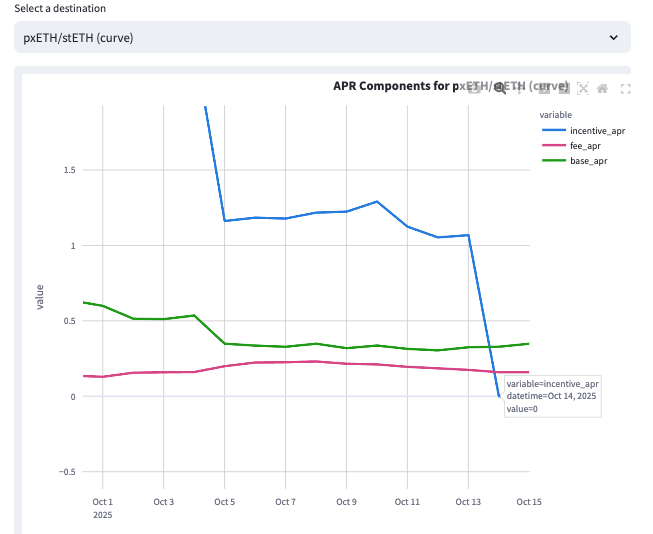

In [ ]:
# can I manually check if rewards are claimable?

In [ ]:
didnt_have_expected_liquidation

In [ ]:
destinations[destinations["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
destination_states[destination_states["destination_vault_address"].isin(didnt_have_expected_liquidation)]

In [ ]:
owned_shares_by_destination = (
    autopool_destination_states[["destination_vault_address", "owned_shares"]]
    .groupby("destination_vault_address")
    .max()
    .reset_index()
)

In [ ]:
def get_list_of_suspect_destinations():
    # a suspect_destination is a destiantion
    # where, the owned shares in the last 3 days is > 1
    # and the incentive apr is > .5
    # and there have been no claim vault rewards in the last 3 days
    pass